In [14]:
import sys

sys.path.append("../")

from utils import open_pickle
from utils import check_solution
from cube3_game import Cube3Game
from models import Pilgrim, PilgrimTransformer, PilgrimSimple, PilgrimCNN, PilgrimMLP2

import numpy as np
import torch

from g_datasets import *
import importlib
import a_search_mix

# Reload the a_search_mix module
importlib.reload(a_search_mix)

# Now you can use AStarVector from the reloaded module
from a_search_mix import AStarVector


In [2]:
optimum = open_pickle("../assets/data/deepcubea/data_0.pkl")
deepcube_res = open_pickle("../assets/data/deepcubea/results.pkl")
report = open_pickle("../assets/reports/Cube3ResnetModel_value_policy_3_8B_14M_search_value_full.pkl")
game = Cube3Game("../assets/envs/qtm_cube3.pickle")
generators = torch.tensor(game.actions, dtype=torch.int64)

In [3]:
state_size = game.actions.shape[1]
hash_vec = torch.randint(0, 1_000_000_000_000, (state_size,))  

In [16]:
set_seed(42)
scrambles, actions, lengths = get_torch_scrambles_3(
    N=10,
    n=30,
    generators=generators,
    hash_vec=hash_vec,
    device="cpu"
)

In [9]:
model_device = "mps"
model = Pilgrim(
    input_dim = 54, 
    hidden_dim1 = 5000, 
    hidden_dim2 = 1000, 
    num_residual_blocks = 4 
) # ~14M

model.load_state_dict(
    torch.load(
        "../assets/models/Cube3ResnetModel_value_policy_3_8B_14M.pt",
        map_location=model_device)
)
model = model.to(model_device)
goal_state = torch.arange(0, 54, dtype=torch.int64)


In [30]:
from tqdm import tqdm

solutions = []
for i, scramble in tqdm(enumerate(scrambles)):
    path_finder = AStarVector(
        model=model,
        generators=generators,
        num_steps=10_000,
        b_exp=10_0000,
        b_keep=1_000,
        temperature=0.0,
        goal_state=goal_state,
        verbose=False,
        device="cpu",
        model_device="mps"
    )

    solution, processed_count = path_finder.search(scramble.unsqueeze(0))
    solutions.append(solution.detach().tolist())

20it [14:27, 43.37s/it]


KeyboardInterrupt: 

In [25]:
true_lengths = [len(s) for s in solutions]

In [36]:
lengths  =[int(l) for l in lengths.tolist()]

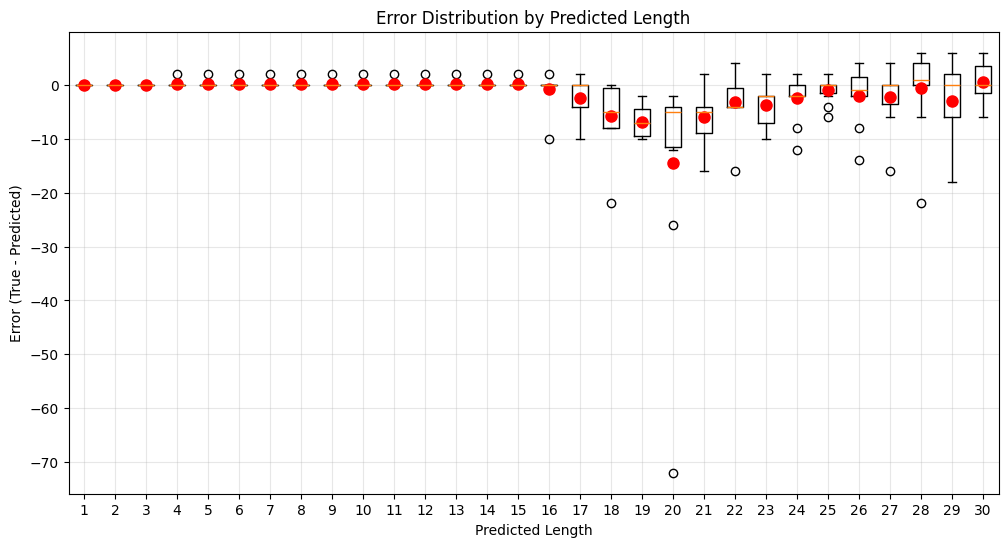


Predicted length: 1
  Number of samples: 10
  Mean error: 0.00
  Median error: 0.00
  Min error: 0
  Max error: 0

Predicted length: 2
  Number of samples: 10
  Mean error: 0.00
  Median error: 0.00
  Min error: 0
  Max error: 0

Predicted length: 3
  Number of samples: 10
  Mean error: 0.00
  Median error: 0.00
  Min error: 0
  Max error: 0

Predicted length: 4
  Number of samples: 10
  Mean error: 0.20
  Median error: 0.00
  Min error: 0
  Max error: 2

Predicted length: 5
  Number of samples: 10
  Mean error: 0.20
  Median error: 0.00
  Min error: 0
  Max error: 2

Predicted length: 6
  Number of samples: 10
  Mean error: 0.20
  Median error: 0.00
  Min error: 0
  Max error: 2

Predicted length: 7
  Number of samples: 10
  Mean error: 0.20
  Median error: 0.00
  Min error: 0
  Max error: 2

Predicted length: 8
  Number of samples: 10
  Mean error: 0.20
  Median error: 0.00
  Min error: 0
  Max error: 2

Predicted length: 9
  Number of samples: 10
  Mean error: 0.20
  Median error: 

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Group errors by predicted length
errors_by_length = defaultdict(list)
for true_len, pred_len in zip(true_lengths, lengths):
    errors_by_length[pred_len].append(pred_len - true_len)

# Sort the predicted lengths
sorted_lengths = sorted(errors_by_length.keys())

# Create box plot
plt.figure(figsize=(12, 6))
plt.boxplot([errors_by_length[length] for length in sorted_lengths])
plt.title('Error Distribution by Predicted Length')
plt.xlabel('Predicted Length')
plt.ylabel('Error (True - Predicted)')
plt.xticks(range(1, len(sorted_lengths) + 1), sorted_lengths)
plt.grid(True, alpha=0.3)

# Add mean markers
for i, length in enumerate(sorted_lengths):
    mean_error = np.mean(errors_by_length[length])
    plt.plot(i + 1, mean_error, 'ro', markersize=8)

plt.show()

# Print statistics for each predicted length
for length in sorted_lengths:
    errors = errors_by_length[length]
    print(f"\nPredicted length: {length}")
    print(f"  Number of samples: {len(errors)}")
    print(f"  Mean error: {np.mean(errors):.2f}")
    print(f"  Median error: {np.median(errors):.2f}")
    print(f"  Min error: {min(errors)}")
    print(f"  Max error: {max(errors)}")

In [38]:
sorted_lengths

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30]